# Sen1Floods11 Dataset

## Generating CSV Files

In [1]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.io import imread
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tqdm.pandas()

ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(f'ROOT: {ROOT}')

ROOT: /mnt/lustre/coe-lstr/home/gahizon/SAR_flood_segmentation


In [2]:
HAND_LABELED = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled')
WEAKLY_LABELED = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'WeaklyLabeled')

hl_folders = ['JRCWaterHand', 'LabelHand', 'S1Hand', 'S1OtsuLabelHand', 'S2Hand']
wl_folders = ['S1OtsuLabelWeak', 'S1Weak', 'S2IndexLabelWeak']

### Hand Labeled

- Train test split is already provided for the Hand Labeled images.
- Process the CSVs such that Region and the unique Image Id is left.
- The file path can be reconstructed during loading.
- Additionally, add the Bolivia images as the "hold out" set.

In [3]:
for folder in hl_folders:
    hl_images = glob(f'{os.path.join(HAND_LABELED, folder)}/*.tif')
    hl_images = [hl_image.split('/')[8].replace(f'_{folder}.tif', '') for hl_image in hl_images]
    print(f'{folder}: {len(hl_images)}')

JRCWaterHand: 446
LabelHand: 446
S1Hand: 446
S1OtsuLabelHand: 446
S2Hand: 446


In [4]:
SPLITS = ['test', 'train', 'valid']
hand_labeled = pd.DataFrame()
for SPLIT in SPLITS:
    FILE = os.path.join(ROOT, 'sen1floods11', f'flood_{SPLIT}_data.csv')
    hl = pd.read_csv(FILE, header=None)
    hl['Region'] = hl[0].str.split('_', expand=True)[0]
    hl['Img_Id'] = hl[0].str.split('_', expand=True)[1]
    hl['Split'] = SPLIT
    hl.drop(columns=[0,1], inplace=True)
    hand_labeled = pd.concat([hand_labeled, hl])

bolivia = glob(f'{os.path.join(HAND_LABELED, folder)}/Bolivia*.tif')
bolivia = [img.split('/')[11].replace(f'_{folder}.tif', '') for img in bolivia]
img_ids = [img.split('_')[1] for img in bolivia]

bolivia_df = pd.DataFrame({
    'Region': ['Bolivia'] * len(img_ids),
    'Img_Id': img_ids,
    'Split': ['hold out'] * len(img_ids)
})

hand_labeled = pd.concat([hand_labeled, bolivia_df])

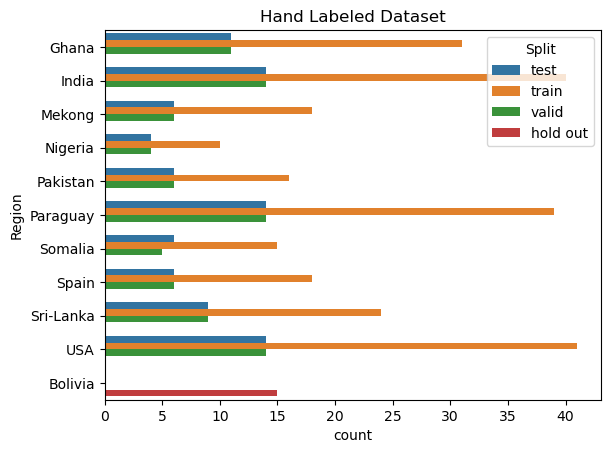

In [5]:
sns.countplot(hand_labeled, y='Region', hue='Split')
plt.title('Hand Labeled Dataset')
plt.show()

### Weakly Labeled
- For the weak labeled images, there we use train_test_split to get an 80:20 split.
- No test set here because we will also use the handlabeled test set.
- We remove all Bolivia images here too to keep the hold out region out of training.

In [6]:
for folder in wl_folders:
    hl_images = glob(f'{os.path.join(WEAKLY_LABELED, folder)}/*.tif')
    hl_images = [hl_image.split('/')[9].replace(f'_{folder}.tif', '') for hl_image in hl_images]
    print(f'{folder}: {len(hl_images)}')

S1OtsuLabelWeak: 4384
S1Weak: 4384
S2IndexLabelWeak: 4384


In [7]:
hl_images = glob(f'{os.path.join(WEAKLY_LABELED, folder)}/*.tif')
hl_images = [hl_image.split('/')[11].replace(f'_{folder}.tif', '') for hl_image in hl_images]
weak_labeled = pd.DataFrame({
    'Region': [hl_image.split('_')[0] for hl_image in hl_images],
    'Img_Id': [hl_image.split('_')[1] for hl_image in hl_images],
})

weak_labeled = weak_labeled.loc[weak_labeled['Region'] !='Bolivia']
train, valid = train_test_split(weak_labeled, test_size=0.2, stratify=weak_labeled['Region'], random_state=42)

train['Split'] = 'train'
valid['Split'] = 'valid'

weak_labeled = pd.concat([train, valid])

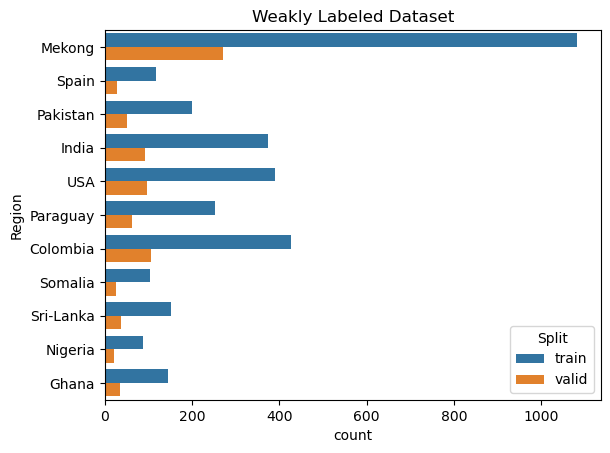

In [8]:
sns.countplot(weak_labeled, y='Region', hue='Split')
plt.title('Weakly Labeled Dataset')
plt.show()

## Take note of SAR images that have NaNs or labels that are pure zeros.

We might need to exclude this out of our dataset.

In [9]:
def check_nans(row, dataset):
    TOTAL = 512**2
    ROOT_PATH = os.path.join(ROOT, 'sen1floods11', 'flood_events')
    
    sub_folder = {
        'HandLabeled': ['S1Hand', 'LabelHand'],
        'WeaklyLabeled': ['S1Weak', 'S2IndexLabelWeak']
    }
    img_path = os.path.join(ROOT_PATH, dataset, sub_folder[dataset][0], f'{row.Region}_{row.Img_Id}_{sub_folder[dataset][0]}.tif')
    label_path = os.path.join(ROOT_PATH, dataset, sub_folder[dataset][1], f'{row.Region}_{row.Img_Id}_{sub_folder[dataset][1]}.tif')
    
    img = imread(img_path)
    label = imread(label_path)
    
    # Calculate the percentage of NaNs in each channel of the image
    nan_percentage_channel_1 = (np.isnan(img[:, :, 0]).sum() / TOTAL) * 100
    nan_percentage_channel_2 = (np.isnan(img[:, :, 1]).sum() / TOTAL) * 100
    
    # Put the higher percentage in row['NaN Pixels']
    row['NaN Pixels'] = max(nan_percentage_channel_1, nan_percentage_channel_2)
    
    # Check if the label doesn't have a "1" pixel
    row['Zero Label'] = not np.any(label == 1)
    
    return row

In [10]:
hand_labeled = hand_labeled.progress_apply(check_nans, axis=1, dataset='HandLabeled')
weak_labeled = weak_labeled.progress_apply(check_nans, axis=1, dataset='WeaklyLabeled')

100%|██████████| 4160/4160 [01:53<00:00, 36.57it/s]


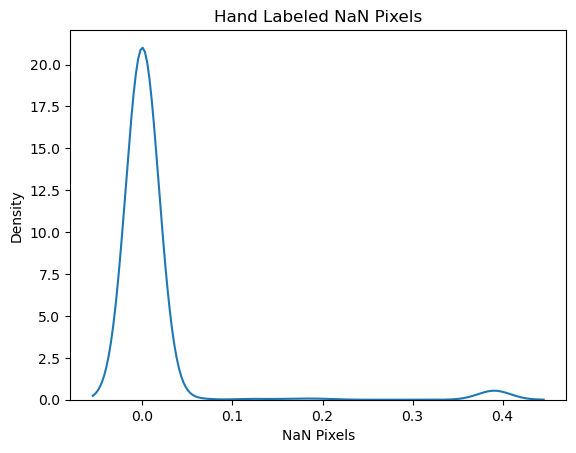

In [11]:
sns.kdeplot(hand_labeled, x='NaN Pixels')
plt.title('Hand Labeled NaN Pixels')
plt.show()

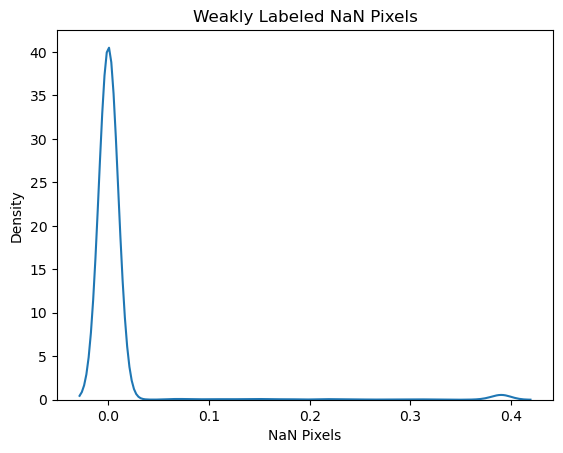

In [12]:
sns.kdeplot(weak_labeled, x='NaN Pixels')
plt.title('Weakly Labeled NaN Pixels')
plt.show()

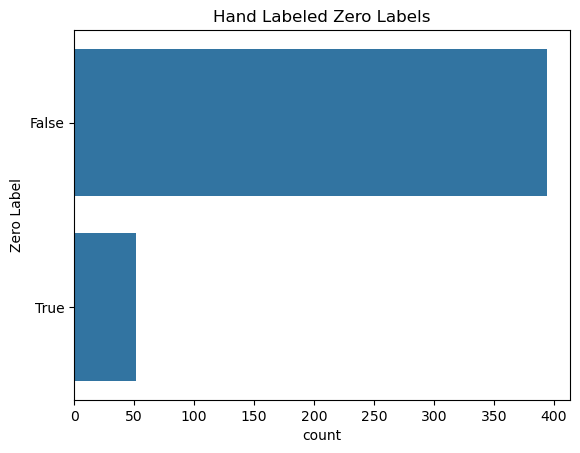

In [13]:
sns.countplot(hand_labeled, y='Zero Label')
plt.title('Hand Labeled Zero Labels')
plt.show()

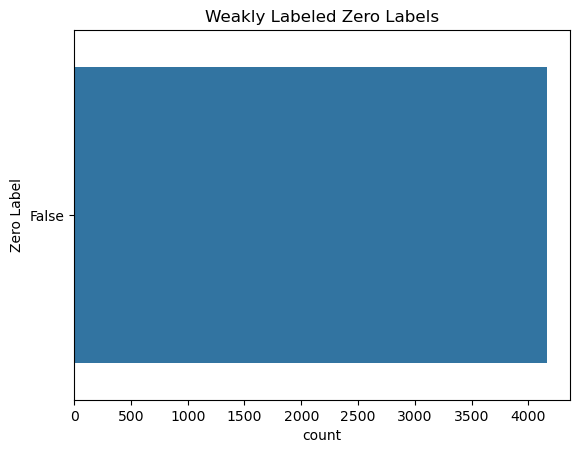

In [14]:
sns.countplot(weak_labeled, y='Zero Label')
plt.title('Weakly Labeled Zero Labels')
plt.show()

### Save the CSVs

In [15]:
hand_labeled.to_csv(os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv'))
weak_labeled.to_csv(os.path.join(ROOT, 'sen1floods11', 'weak_labeled.csv'))